In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/simple-dialogs-for-chatbot/dialogs.txt


In [14]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 34.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.1 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 48.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 30.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
p

In [15]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline


importing dataset

In [16]:
columns = ['question', 'answer']
df = pd.read_csv('/kaggle/input/simple-dialogs-for-chatbot/dialogs.txt', sep='\t', names=columns)

In [17]:

df.head(10)

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.
5,i've been good. i'm in school right now.,what school do you go to?
6,what school do you go to?,i go to pcc.
7,i go to pcc.,do you like it there?
8,do you like it there?,it's okay. it's a really big campus.
9,it's okay. it's a really big campus.,good luck with school.


EDA
checking for missing value
check datatype,get overview

In [18]:
print(df.dtypes)
print(df.isnull().sum())

question    object
answer      object
dtype: object
question    0
answer      0
dtype: int64


convert object to string

In [19]:
df['question'] = df['question'].astype("string")
df['answer'] = df['answer'].astype("string")
print(df.dtypes)


question    string[python]
answer      string[python]
dtype: object


word frequency analysis

In [20]:
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    words = text.split()  # Tokenize (split into words)
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words


In [22]:
all_questions = df['question'].dropna().apply(preprocess_text).sum()
all_answers = df['answer'].dropna().apply(preprocess_text).sum()


In [23]:
question_freq = Counter(all_questions)
answer_freq = Counter(all_answers)

# Get the 10 most common words
print("Most Common Words in Questions:", question_freq.most_common(10))
print("Most Common Words in Answers:", answer_freq.most_common(10))


Most Common Words in Questions: [('like', 171), ('yes', 151), ('go', 128), ('think', 115), ('going', 104), ('good', 103), ('want', 97), ('really', 96), ('know', 92), ('get', 88)]
Most Common Words in Answers: [('yes', 173), ('like', 167), ('go', 122), ('think', 122), ('good', 108), ('going', 104), ('get', 101), ('well', 98), ('want', 95), ('really', 94)]


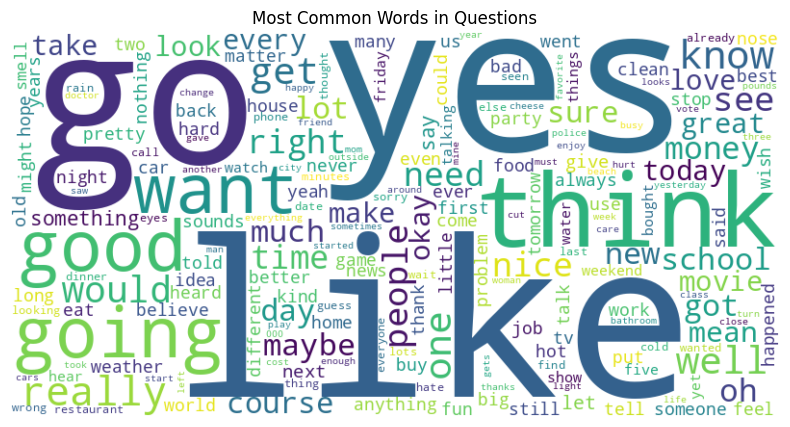

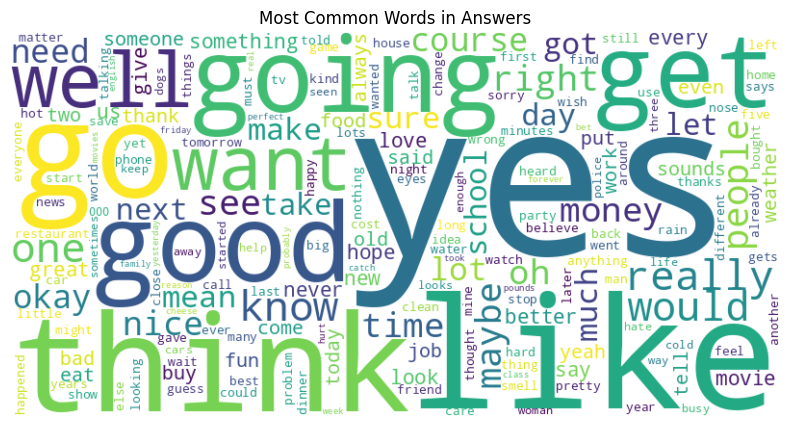

In [24]:
def plot_wordcloud(word_freq, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(question_freq, "Most Common Words in Questions")
plot_wordcloud(answer_freq, "Most Common Words in Answers")


using spacy for lemmatization

In [25]:
!pip install spacy
import spacy


In [26]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.9 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [27]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    doc = nlp(text)  # Process text with spaCy
    words = [token.lemma_ for token in doc if token.text not in stop_words]
    return " ".join(words)

df['clean_question'] = df['question'].dropna().apply(clean_text)
df['clean_answer'] = df['answer'].dropna().apply(clean_text)


convert string to embeddings

In [28]:
!pip show tokenizers
!pip show transformers
!pip show sentence-transformers


Name: tokenizers
Version: 0.13.3
Summary: Fast and Customizable Tokenizers
Home-page: https://github.com/huggingface/tokenizers
Author: Anthony MOI
Author-email: anthony@huggingface.co
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: transformers
Name: transformers
Version: 4.27.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, tokenizers, tqdm
Required-by: kaggle-environments, peft, sentence-transformers
Name: sentence-transformers
Version: 3.4.1
Summary: State-of-the-Art Text Embeddings
Home-page: https://

In [31]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
question_embeddings = model.encode(df['clean_question'].tolist())


Batches:   0%|          | 0/117 [00:00<?, ?it/s]

retrieving the top-matching answer using FAISS and generating a response using an LLM.

In [32]:
!pip install faiss-cpu sentence-transformers transformers


  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 106.7 MB/s eta 0:00:0000:01
Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 87.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.2
    Uninstalling transformers-4.27.2:
      Successfully uninstalled transformers-4.27.2


In [33]:
import faiss
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# Load sentence transformer model for embeddings
embedder = SentenceTransformer("all-MiniLM-L6-v2")


In [34]:


# Encode all questions into embeddings
question_embeddings = embedder.encode(df['question'].tolist())

# Convert embeddings to FAISS index
dimension = question_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance index
index.add(np.array(question_embeddings))  # Add embeddings to index


Batches:   0%|          | 0/117 [00:00<?, ?it/s]

In [35]:
import torch
from transformers import pipeline

# Load the LLaMA 2 model for text generation
llm = pipeline(
    "text-generation",
    model="tiiuae/falcon-7b-instruct",
    device=0 if torch.cuda.is_available() else -1
     truncation=True 
)
def get_similar_answer(user_question, k=3):
    # Convert user question to an embedding
    user_embedding = embedder.encode([user_question])

    # Search FAISS index for top K similar questions
    _, idx = index.search(np.array(user_embedding), k)
    
    # Retrieve top-matching answers
    top_answers = [df['answer'].iloc[i] for i in idx[0]]

    # Combine retrieved answers for LLM input
    prompt = f"User Question: {user_question}\nRetrieved Answers: {' '.join(top_answers)}\nProvide a helpful response based on the retrieved answers."

    # Generate a response using LLM
    response = llm(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    
    return response

# Test the chatbot
user_input = "What is machine learning?"
print(get_similar_answer(user_input))


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

Device set to use cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


User Question: What is machine learning?
Retrieved Answers: yes, it will only take about 30 minutes. it's the force that pulls everything down. it gives you money?
Provide a helpful response based on the retrieved answers.
Machine learning is a branch of artificial intelligence that focuses on the development of computer programs that can learn from data and improve their performance over time. It involves the use of algorithms to analyze data and identify patterns, which can then be used to make


llama2 not compatible with LoRA finetuning so i use another approach.

In [ ]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
from transformers import Trainer, TrainingArguments

# Load the tokenizer and model for Falcon 7B
model_name = "tiiuae/falcon-7b-instruct"  # Or choose another model if you wish
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Load your custom Q&A data 
data = {
    'question': df['question'].tolist(),
    'answer': df['answer'].tolist()
}
# Convert to Hugging Face dataset
dataset = Dataset.from_dict(data)

# Tokenize the dataset
def tokenize_data(example):
    prompt = f"Question: {example['question']}\nAnswer: {example['answer']}"
    return tokenizer(prompt, truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_data, batched=True)

# Prepare Training Arguments
training_args = TrainingArguments(
    output_dir="./results",  # Directory to save results
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    learning_rate=2e-5,  # Set learning rate
    per_device_train_batch_size=4,  # Adjust based on GPU memory
    per_device_eval_batch_size=4,  # Adjust based on GPU memory
    num_train_epochs=3,  # Number of epochs
    weight_decay=0.01,  # Regularization
    logging_dir="./logs",  # Directory for logging
    logging_steps=10,  # Frequency of logging
    save_steps=500,  # Frequency of saving the model
)

# Initialize Trainer
trainer = Trainer(
    model=model,  # The model to train
    args=training_args,  # Training arguments
    train_dataset=tokenized_dataset,  # Training dataset
    eval_dataset=tokenized_dataset,  # Evaluation dataset (can be separate)
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_model")

# Load the fine-tuned model for inference
model = AutoModelForCausalLM.from_pretrained("./fine_tuned_model")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_model")

# LLM pipeline for text generation after fine-tuning
llm = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

def get_similar_answer(user_question, k=3):
    # Convert user question to an embedding
    user_embedding = embedder.encode([user_question])

    # Search FAISS index for top K similar questions
    _, idx = index.search(np.array(user_embedding), k)
    
    # Retrieve top-matching answers
    top_answers = [df['answer'].iloc[i] for i in idx[0]]

    # Combine retrieved answers for LLM input
    prompt = f"User Question: {user_question}\nRetrieved Answers: {' '.join(top_answers)}\nProvide a helpful response based on the retrieved answers."

    # Generate a response using fine-tuned LLM
    response = llm(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    
    return response

# Test the fine-tuned chatbot
user_input = "What is machine learning?"
print(get_similar_answer(user_input))


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]